In [1]:
SEED = 42
PYTORCH_PRETRAINED_BERT_CACHE = "/mnt/Intel/bert_tmp"

In [2]:
# Local network environment settings
import os
os.environ["http_proxy"] = "127.0.0.1:11233"
os.environ["https_proxy"] = "127.0.0.1:11233"

In [3]:
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("bert")

In [4]:
import json
import gc

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.modeling import BertForNextSentencePrediction
from pytorch_pretrained_bert.tokenization import BertTokenizer
# from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear, SCHEDULES
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import StratifiedShuffleSplit

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import random
import numpy as np

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

## Data Preparation

In [7]:
with open("NYTimesEN.json") as fin:
    entries = json.load(fin)
df_full = pd.DataFrame([{"title": x[0], "desc": x[1]} for x in entries.values()])
df_full.desc.str.len().describe()

count    3029.000000
mean      121.599538
std        66.155573
min         0.000000
25%        80.000000
50%       128.000000
75%       165.000000
max       789.000000
Name: desc, dtype: float64

In [8]:
print(df_full.shape[0], df_full[df_full.desc.str.len() >= 10].shape[0], df_full[df_full.desc.str.len() > 200].shape[0])

3029 2719 286


In [9]:
df_full = df_full[df_full.desc.str.len() >= 10].copy()

In [10]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target

In [11]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [12]:
def convert_sentence_pair(titles, descs, max_seq_length, tokenizer):
    features = []
    for (ex_index, (title, desc)) in enumerate(zip(titles, descs)):
        tokens_a = tokenizer.tokenize(title)

        tokens_b = None
        tokens_b = tokenizer.tokenize(desc)
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

        features.append(
                InputFeatures(
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    target=1
        ))
    return features

In [13]:
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased", do_lower_case=True, 
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE)

02/09/2019 16:27:12 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /mnt/Intel/bert_tmp/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [14]:
correct_pairs = convert_sentence_pair(df_full.title.tolist(), df_full.desc.tolist(), max_seq_length=200, tokenizer=tokenizer)

02/09/2019 16:27:12 - INFO - bert -   *** Example ***
02/09/2019 16:27:12 - INFO - bert -   tokens: [CLS] four simple words to help you live well [SEP] this year , take a small step every day to build healthy habits for your body , mind and spirit . [SEP]
02/09/2019 16:27:12 - INFO - bert -   input_ids: 101 2176 3722 2616 2000 2393 2017 2444 2092 102 2023 2095 1010 2202 1037 2235 3357 2296 2154 2000 3857 7965 14243 2005 2115 2303 1010 2568 1998 4382 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
02/09/2019 16:27:12 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

02/09/2019 16:27:12 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [15]:
len(correct_pairs)

2719

## Model

In [16]:
model = BertForNextSentencePrediction.from_pretrained(
    "bert-base-uncased",
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE
).to(device)

02/09/2019 16:27:15 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /mnt/Intel/bert_tmp/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
02/09/2019 16:27:15 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /mnt/Intel/bert_tmp/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmped9o0vcm
02/09/2019 16:27:17 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

02/09/2019

## Eval Correct Pairs

In [17]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in correct_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in correct_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in correct_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

02/09/2019 16:27:21 - INFO - bert -   ***** Running evaluation *****
02/09/2019 16:27:21 - INFO - bert -     Num examples = 2719
02/09/2019 16:27:21 - INFO - bert -     Batch size = 128


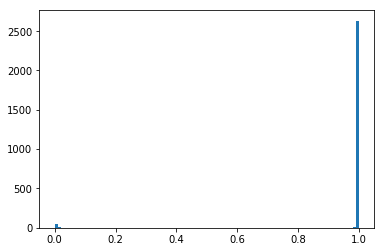

In [18]:
_ = plt.hist(res, bins=100)

In [19]:
sum(res > 0.99) / len(res), sum(res > 0.9) / len(res), sum(res < 0.5) / len(res)

(0.9683707245310776, 0.9738874586244943, 0.025376976829716808)

In [20]:
np.where(res < 0.5)

(array([  33,   75,   79,  163,  176,  196,  209,  241,  245,  261,  319,
         338,  435,  445,  473,  474,  476,  654,  673,  725,  741,  746,
         760,  770,  798,  800,  807,  840,  863,  906,  915,  970,  996,
        1078, 1080, 1159, 1193, 1195, 1203, 1276, 1483, 1627, 1649, 1683,
        1764, 1790, 1834, 1836, 1838, 1925, 1926, 1942, 1994, 2134, 2140,
        2210, 2317, 2323, 2378, 2411, 2417, 2444, 2446, 2468, 2509, 2593,
        2617, 2668, 2672]),)

In [21]:
idx = 2672
df_full.iloc[idx].title, df_full.iloc[idx].desc

('Meanwhile: For a Knife, Dagger, Sword, Machete or Zombie-Killer, Just Ask These Ladies',
 "Whitehead's Cutlery in Butte, Mont., is 128 years old and will gladly sharpen scissors sold generations ago.")

## Find similar entries

In [22]:
df_full.iloc[102].to_dict()

{'desc': 'Transportation Security Administration officers checking passengers at Pittsburgh International Airport last week. The agency’s employees have called out sick in increased numbers across the country since the shutdown began.',
 'title': 'What Is and Isn’t Affected by the Government Shutdown'}

In [23]:
idx = 102
sentence_pairs = convert_sentence_pair(
    [df_full.iloc[idx]["title"]] * df_full.shape[0], 
    df_full.desc.tolist(), max_seq_length=200, tokenizer=tokenizer)

02/09/2019 16:27:53 - INFO - bert -   *** Example ***
02/09/2019 16:27:53 - INFO - bert -   tokens: [CLS] what is and isn ’ t affected by the government shut ##down [SEP] this year , take a small step every day to build healthy habits for your body , mind and spirit . [SEP]
02/09/2019 16:27:53 - INFO - bert -   input_ids: 101 2054 2003 1998 3475 1521 1056 5360 2011 1996 2231 3844 7698 102 2023 2095 1010 2202 1037 2235 3357 2296 2154 2000 3857 7965 14243 2005 2115 2303 1010 2568 1998 4382 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
02/09/2019 16:27:53 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

02/09/2019 16:27:53 - INFO - bert -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [24]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in sentence_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in sentence_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in sentence_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

02/09/2019 16:27:54 - INFO - bert -   ***** Running evaluation *****
02/09/2019 16:27:54 - INFO - bert -     Num examples = 2719
02/09/2019 16:27:54 - INFO - bert -     Batch size = 128


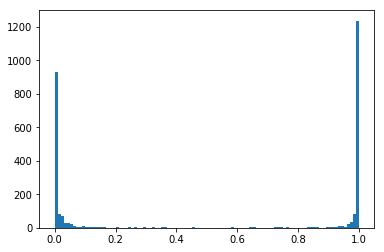

In [25]:
_ = plt.hist(res, bins=100)

In [26]:
best_matches = np.argsort(res)[::-1][:10]
best_matches

array([ 995,  160,  364,  223,  929,  795, 1786, 1019,  514, 1702])

In [27]:
from pprint import pprint
for _, row in df_full.iloc[best_matches].iterrows():
    pprint(row.to_dict())

{'desc': 'Transportation Security Administration agents are among the most '
         'visible federal employees affected by the government shutdown.',
 'title': 'It’s Time for T.S.A. Workers to Strike'}
{'desc': 'Transportation Security Administration agents at Chicago Midway '
         'International Airport on Dec. 22, the first day of the government '
         'shutdown.',
 'title': 'T.S.A. Screeners, Working Without Pay, Are Calling Out Sick'}
{'desc': 'Damage from Hurricane Michael lingers throughout Marianna, Fla. The '
         'government shutdown has made things worse for many residents.',
 'title': '‘It’s Just Too Much’: A Florida Town Grapples With a Shutdown After '
          'a Hurricane'}
{'desc': 'Scientists aboard a National Oceanic and Atmospheric Administration '
         'ship in San Juan, P.R. The administration has furloughed many '
         'workers because of the government shutdown.',
 'title': 'Toll on Science and Research Mounts as Government Shutdown '
     